# Quantum state tomography (QST) with Gradient descent (GD) 

## Using the method of Manifold

## Note 1:

For the GD methods it is necesary the library Jax (https://github.com/google/jax). Also QuTip is a very important library.

In [2]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library 
import os


from qutip import *
from itertools import *
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp
#from qutip import basis, tensor

# Libraries for the different methods of doing QST with GD
from qst_tec.gdmanifold import gd_manifold, mix_rho, Nkets, softmax, expect_prob_ket
from qst_tec.gdmanifold_adaptive import gd_manifold_adaptive, mix_rho, Nkets, softmax, expect_prob_ket


import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
from jax import config
config.update("jax_enable_x64", True) # We want float64 for better precision
import optax

from tqdm.auto import tqdm   # For the progressbars
import time

### First we will define the number of qubits and the measurement operators. We will use the Pauli matrices.

In [3]:
number_qubits: int = 3
dimension: int = 2**number_qubits
HS: int = dimension


# Creating the Measurement operators (Pauli matrices)

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
pauli_sys = [tensor(*op) for op in product(pauli, repeat=number_qubits)] # using itertools

Measu_ope = [Qobj(pauli_sys[i], dims=([[2**number_qubits], [2**number_qubits]])) for i in range(len(pauli_sys))]

print(Measu_ope[1:3])

#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]], Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]]]


## The ansatz

We need to create an ansatz that is 1 array with the state vectors and the square root probability values
$$\begin{bmatrix}
\sqrt{p_1}\ket{\psi_1} \\
\cdot \\[-7pt]
\cdot \\[-7pt]
\cdot  \\
\sqrt{p_m}\ket{\psi_m} 
\end{bmatrix}$$



e.g for the case of 1 qubit with rank 2 will be 
$$\mathcal{W} = \begin{bmatrix}
    \sqrt{p_1}\alpha_1 \\
    \sqrt{p_1}\beta_1 \\
    \sqrt{p_2}\alpha_2 \\
    \sqrt{p_2}\beta_2 
    \end{bmatrix}$$

In [4]:
def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the GD manifold
    
    Args: 
        kn (int) : rank number
    
    Output:
        column_ket_pro : Ansatz GD-manifold
    
    """

    ketl1 = Nkets(kn, HS)   # generate kn random kets with hilbert space HS
    ketl1_np = [a.full() for a in ketl1]
    ketl2 = [a.full().flatten() for a in ketl1]
    ketl2_np = np.asarray(ketl2)
    ketl2_jnp = jnp.asarray(ketl2)
    ketl1_jnp = jnp.asarray(ketl1_np)
    prob1_array = np.random.rand(kn) # create the second list for the random probabilities
    prob1_array = softmax(prob1_array)
    prob1_array_jnp = jnp.asarray(prob1_array)


    # --- column ket for GD manifold ------------------------
    prob_sqrt = jnp.sqrt(prob1_array_jnp) 
    prob1_array_reshaped = prob_sqrt[:, jnp.newaxis]
    ket_prob_o = prob1_array_reshaped * ketl2_jnp 
    ket_prob = ket_prob_o.flatten()
    column_ket_pro = ket_prob[:, np.newaxis]
    
    return column_ket_pro

Visualizing the structure of the ansatz (optional)


In [5]:
print(ansatz(2))

[[-0.10075102+0.34029963j]
 [ 0.04571789+0.17370621j]
 [ 0.0147265 -0.20723925j]
 [-0.136573  +0.2652297j ]
 [ 0.34951706-0.07481531j]
 [ 0.15431786-0.29294178j]
 [-0.08043674-0.02175773j]
 [ 0.31561452+0.17898313j]
 [-0.20912222+0.00697151j]
 [-0.05867204-0.06086067j]
 [-0.11382539-0.03960251j]
 [ 0.07539637-0.1773271j ]
 [-0.13905293-0.21022062j]
 [ 0.21911825-0.13051928j]
 [ 0.27242498+0.08972465j]
 [ 0.01590421+0.1412853j ]]


## Implementing the GD Manifold 

In [6]:
# List to save the values of fidelity and time for the GD methods

fid_list_mani, fid_list_mani_adaptive = [], []
time_list_mani, time_list_mani_adaptive = [], []


# defining the number of iterations for the GD method
max_itera: int = 500
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 
# in this case we are taking the 50% of the measurement operators

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(2**number_qubits)
data = qtp.expect(Measu_ope,rho_or)

# calling the ansatz
rank: int = 2**number_qubits # maximum rank is 2**N
column_ket_pro = ansatz(rank)


# ...........................................................................
    # GD-QST-manifold
rho_gd_mani, f_gd_mani, t_gd_mani, loss_gd_mani = gd_manifold(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                           lr=0.1, decay=0.997, lamb=0, tqdm_off=False)   
fid_list_mani.append(f_gd_mani)
time_list_mani.append(t_gd_mani)
             
    # ...........................................................................                                  
    # GD-QST-manifold-adaptive
rho_gd_mani_adaptive, f_gd_mani_adaptive, t_gd_mani_adaptive, _ = gd_manifold_adaptive(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                            lr=1e-1, boost = 1.08, decay = 0.99, lamb = 0, tqdm_off=False)
fid_list_mani_adaptive.append(f_gd_mani_adaptive)
time_list_mani_adaptive.append(t_gd_mani_adaptive)
    

Fidelity GD-manifold-adaptive 0.9977: 100%|██████████| 500/500 [00:02<00:00, 193.08it/s]


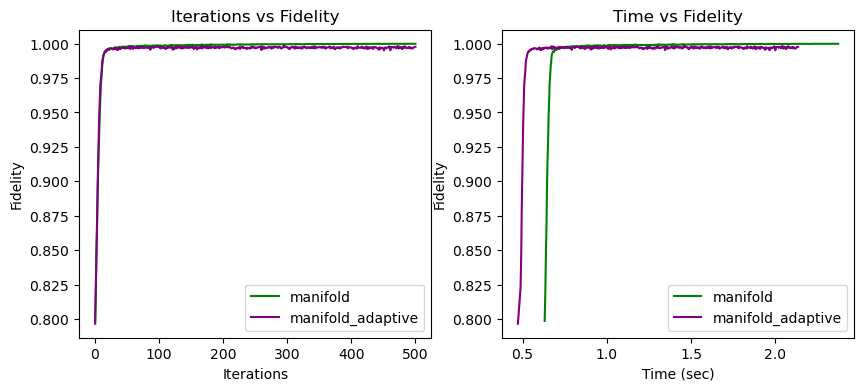

In [7]:
fid_list_mani = np.array(fid_list_mani)
fid_list_mani_adaptive = np.array(fid_list_mani_adaptive)
mean_fid_mani = np.mean(fid_list_mani, axis=0)
mean_fid_mani_adaptive = np.mean(fid_list_mani_adaptive, axis=0)
time_list_mani = np.array(time_list_mani)
time_list_mani_adaptive = np.array(time_list_mani_adaptive)
mean_time_mani = np.mean(time_list_mani, axis=0)
mean_time_mani_adaptive = np.mean(time_list_mani_adaptive, axis=0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_mani)+1)   # total number of iterations


ax1.plot(iterations, mean_fid_mani, color='green',label="manifold")

ax1.plot(iterations, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)


ax2.plot(mean_time_mani, mean_fid_mani, color='green',label="manifold")

ax2.plot(mean_time_mani_adaptive, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()

In [8]:
print('max fidelity (chol_manifold) and time:', [np.max(f_gd_mani), mean_time_mani[np.argmax(mean_fid_mani)]])
print('max fidelity (chol_manifold_adaptive):', [np.max(f_gd_mani_adaptive), mean_time_mani_adaptive[np.argmax(mean_fid_mani_adaptive)]])


max fidelity (chol_manifold) and time: [0.9999060555583024, 2.340759754180908]
max fidelity (chol_manifold_adaptive): [0.9984381825990227, 1.4620835781097412]


## GHZ state
Now let's reconstruct a GHZ state
$$ \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

In [9]:
# Define the basis states |0> and |1> for a single qubit
zero = qtp.basis(2, 0)  # |0>
one = qtp.basis(2, 1)   # |1>

# Construct the |000> and |111> states for 3 qubits
state_000 = qtp.tensor(zero, zero, zero)  # |000>
state_111 = qtp.tensor(one, one, one)     # |111>

# Create the GHZ state: (|000> + |111>) / sqrt(2)
ghz_state = (state_000 + state_111).unit()
ghz_state = qtp.Qobj(ghz_state.full(), dims=[[8], [1]])  # Reshape the GHZ state to have dimensions [8]
# This reshape is necessary for the function qtp.expect. It will depend of the version of QuTip
rho_ghz = tensor(ghz_state, ghz_state.dag())
print(ghz_state)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket'
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [10]:
# List to save the values of fidelity and time for the GD methods

fid_list_mani, fid_list_mani_adaptive = [], []
time_list_mani, time_list_mani_adaptive = [], []


# defining the number of iterations for the GD method
max_itera: int = 500
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 
# in this case we are taking the 50% of the measurement operators

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = ghz_state
data = qtp.expect(Measu_ope,rho_or)

# calling the ansatz
rank: int = 1 # maximum rank is 2**N
column_ket_pro = ansatz(rank)


# ...........................................................................
    # GD-QST-manifold
rho_gd_mani, f_gd_mani, t_gd_mani, loss_gd_mani = gd_manifold(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                           lr=0.1, decay=0.997, lamb=0, tqdm_off=False)   
fid_list_mani.append(f_gd_mani)
time_list_mani.append(t_gd_mani)
             
    # ...........................................................................                                  
    # GD-QST-manifold-adaptive
rho_gd_mani_adaptive, f_gd_mani_adaptive, t_gd_mani_adaptive, _ = gd_manifold_adaptive(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                            lr=1e-1, boost = 1.08, decay = 0.99, lamb = 0, tqdm_off=False)
fid_list_mani_adaptive.append(f_gd_mani_adaptive)
time_list_mani_adaptive.append(t_gd_mani_adaptive)
    

Fidelity GD-manifold-adaptive 0.9991: 100%|██████████| 500/500 [00:01<00:00, 341.92it/s]


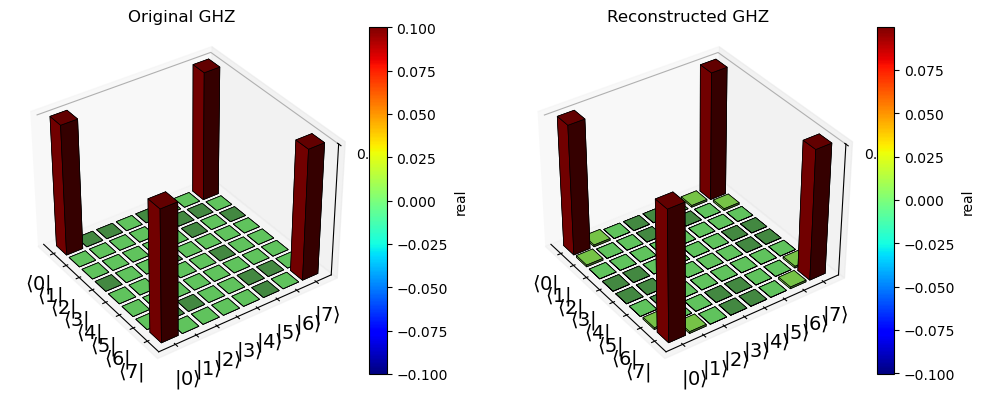

In [11]:
rho_ghz = tensor(ghz_state, ghz_state.dag())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": "3d"})

# Plot the first matrix histogram
matrix_histogram(rho_ghz, ax=axes[0])
axes[0].set_title("Original GHZ")

# Plot the second matrix histogram
matrix_histogram(rho_gd_mani, ax=axes[1])
axes[1].set_title("Reconstructed GHZ")

# Show the plots
plt.show()

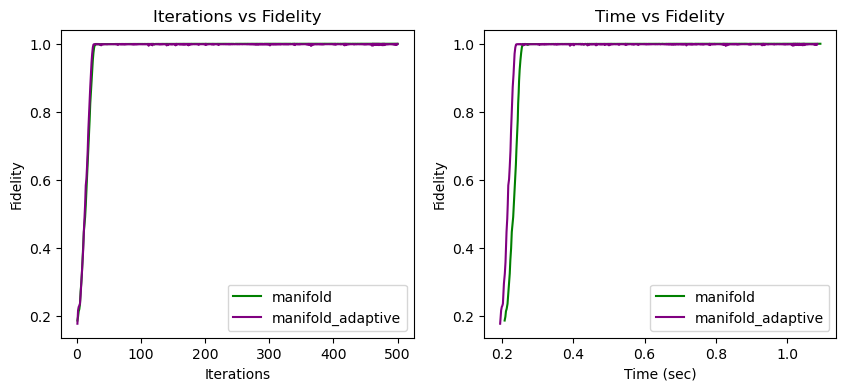

In [12]:
fid_list_mani = np.array(fid_list_mani)
fid_list_mani_adaptive = np.array(fid_list_mani_adaptive)
mean_fid_mani = np.mean(fid_list_mani, axis=0)
mean_fid_mani_adaptive = np.mean(fid_list_mani_adaptive, axis=0)
time_list_mani = np.array(time_list_mani)
time_list_mani_adaptive = np.array(time_list_mani_adaptive)
mean_time_mani = np.mean(time_list_mani, axis=0)
mean_time_mani_adaptive = np.mean(time_list_mani_adaptive, axis=0)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_mani)+1)   # total number of iterations


ax1.plot(iterations, mean_fid_mani, color='green',label="manifold")

ax1.plot(iterations, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)


ax2.plot(mean_time_mani, mean_fid_mani, color='green',label="manifold")

ax2.plot(mean_time_mani_adaptive, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()